In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import pickle
import os

In [2]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

print(tf.__version__)


2.3.1


In [3]:
emotion_label = 'mouth'

In [4]:
# fetch data from records
folder = f'data/landmark_records/{emotion_label}'
print(f'{folder} exists: {os.path.exists(folder)}')

data/landmark_records/mouth exists: True


In [5]:
records_number = len(os.listdir(folder))
print(records_number)

18


In [6]:
records = []
for i in range(records_number):
    with open(f'{folder}/record_{i}.pickle','rb') as pickle_in:
        record = pickle.load(pickle_in)
    records.append(record)

In [7]:
records[0]

[(0.006602358818054199,
  array([[148, 130],
         [150, 146],
         [153, 162],
         [156, 178],
         [161, 194],
         [168, 208],
         [178, 220],
         [190, 228],
         [205, 230],
         [220, 227],
         [232, 218],
         [241, 206],
         [248, 191],
         [251, 175],
         [254, 159],
         [257, 143],
         [257, 127],
         [154, 112],
         [161, 103],
         [172, 100],
         [184, 100],
         [195, 104],
         [215, 105],
         [225, 101],
         [236, 101],
         [245, 104],
         [251, 112],
         [207, 120],
         [208, 130],
         [209, 141],
         [210, 152],
         [197, 162],
         [202, 164],
         [208, 165],
         [213, 164],
         [217, 162],
         [168, 122],
         [174, 117],
         [183, 118],
         [190, 123],
         [182, 125],
         [174, 125],
         [218, 124],
         [225, 119],
         [233, 118],
         [240, 122],
         [

In [8]:
def detail_point_id(id):
    id += 1
    if id <= 17:
        return f'contour_visage_{id}'
    if id <= 22:
        return f'sourcil_droit_{id}'
    if id <= 27:
        return f'sourcil_gauche_{id}'
    if id <= 31:
        return f'crete_nez_{id}'
    if id <= 36:
        return f'bas_nez_{id}'
    if id <= 42:
        return f'oeil_droit_{id}'
    if id <= 48:
        return f'oeil_gauche_{id}'
    if id <= 60:
        return f'levres_exterieur_{id}'
    if id <= 68:
        return f'levres_interieur_{id}'

In [9]:
LANDMARK_SIZE = 68
points_detailed_names = list(map(detail_point_id,range(LANDMARK_SIZE)))
coord_columns = [f'{point_name}_{coord}' for point_name in points_detailed_names for coord in ['x','y']]
dataset_columns = ['mu'] + coord_columns
dataset_columns_with_transform_info = ['mu', 'diameter', 'barycenter_x', 'barycenter_y'] + coord_columns

In [10]:
number_of_landmarks = sum([len(record) for record in records])
print(number_of_landmarks)

951


In [11]:
from scipy.spatial import ConvexHull
from math import sqrt

def compute_diameter(landmark):
    hull = ConvexHull(np.array(landmark))
    diameter = 0
    for i in hull.vertices:
        for j in hull.vertices:
            dist = sqrt(sum((np.array(landmark[i])-np.array(landmark[j]))**2))
            diameter = max(diameter,dist)
    return diameter

In [12]:
def normalize_landmark(landmark, transform_info = False):
    n = len(landmark)
    barycenter = sum(np.array(landmark))/n
    diameter = compute_diameter(landmark)
    normalized_landmark = ((np.array(landmark)-barycenter)/diameter).flatten()
    if transform_info:
        normalized_landmark = np.concatenate((np.array([diameter]), barycenter, normalized_landmark))
    return normalized_landmark

In [13]:
add_transform_info = False

data = np.ndarray((number_of_landmarks, 2*LANDMARK_SIZE+(4 if add_transform_info else 1)), dtype=object)
landmarks = [(mu,landmark) for record in records for mu,landmark in record]
for i, (mu,landmark) in enumerate(landmarks):
    data[i] = np.concatenate((np.array([mu]), normalize_landmark(landmark, transform_info=add_transform_info)))

In [14]:
raw_dataset = pd.DataFrame(data, columns = (dataset_columns_with_transform_info if add_transform_info else dataset_columns))

In [15]:
dataset = raw_dataset.copy()

In [16]:
dataset.isna().sum()

mu                       0
contour_visage_1_x       0
contour_visage_1_y       0
contour_visage_2_x       0
contour_visage_2_y       0
                        ..
levres_interieur_66_y    0
levres_interieur_67_x    0
levres_interieur_67_y    0
levres_interieur_68_x    0
levres_interieur_68_y    0
Length: 137, dtype: int64

In [17]:
train_dataset = dataset.sample(frac = 0.8, random_state = 0)
test_dataset = dataset.drop(train_dataset.index)

In [18]:
train_dataset

,mu,contour_visage_1_x,contour_visage_1_y,contour_visage_2_x,contour_visage_2_y,contour_visage_3_x,contour_visage_3_y,contour_visage_4_x,contour_visage_4_y,contour_visage_5_x,...,levres_interieur_64_x,levres_interieur_64_y,levres_interieur_65_x,levres_interieur_65_y,levres_interieur_66_x,levres_interieur_66_y,levres_interieur_67_x,levres_interieur_67_y,levres_interieur_68_x,levres_interieur_68_y
873,0.663454,-0.303454,-0.237542,-0.31073,-0.135677,-0.303454,-0.0338122,-0.281626,0.0753285,-0.267074,...,-0.00513603,0.220849,0.0894526,0.235402,-0.00513603,0.184469,-0.0487923,0.184469,-0.0924486,0.169917
568,0.25706,-0.496118,-0.217666,-0.477555,-0.0939094,-0.446616,0.036035,-0.415677,0.159792,-0.359986,...,0.0917255,0.190731,0.128852,0.209294,0.0917255,0.234046,0.0484107,0.246421,0.0112837,0.246421
249,0.771403,-0.548963,0.0831278,-0.481103,0.191703,-0.406458,0.293492,-0.325027,0.374923,-0.216452,...,0.170347,0.117057,0.204277,0.110272,0.183919,0.198489,0.156775,0.225633,0.11606,0.239204
331,0.425385,-0.364573,-0.123529,-0.35352,-0.00747675,-0.336942,0.103049,-0.303784,0.208049,-0.2651,...,0.0388466,0.125154,0.121741,0.163838,0.0388466,0.180417,-0.00536376,0.185944,-0.0495741,0.185944
492,0.727428,-0.553896,-0.144606,-0.524838,0.000683717,-0.489969,0.13435,-0.443476,0.250582,-0.367925,...,0.114437,0.163408,0.137684,0.198278,0.114437,0.273829,0.0911908,0.285452,0.0621328,0.291264
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117,0.236489,-0.526874,-0.302345,-0.542234,-0.156424,-0.542234,-0.0181836,-0.534554,0.120057,-0.488474,...,0.0721699,0.204538,0.08753,0.235258,0.0568098,0.242938,0.0260896,0.242938,-0.00463062,0.242938
464,0.046952,-0.596431,-0.116916,-0.565901,0.0174206,-0.529263,0.145651,-0.474308,0.261668,-0.401033,...,0.136312,0.1945,0.172949,0.1945,0.136312,0.206713,0.105781,0.218925,0.0691437,0.225031
25,0.500461,-0.39778,-0.205184,-0.390876,-0.0878201,-0.363261,0.0295441,-0.342549,0.140005,-0.30803,...,0.0440624,0.16762,0.0923888,0.22285,0.0440624,0.271176,0.00263968,0.27808,-0.0318792,0.271176
110,0.100331,-0.517823,-0.306801,-0.532864,-0.163907,-0.540385,-0.0210137,-0.525344,0.114359,-0.480219,...,0.0687924,0.204608,0.0913545,0.23469,0.0612717,0.22717,0.0236681,0.22717,-0.00641472,0.22717


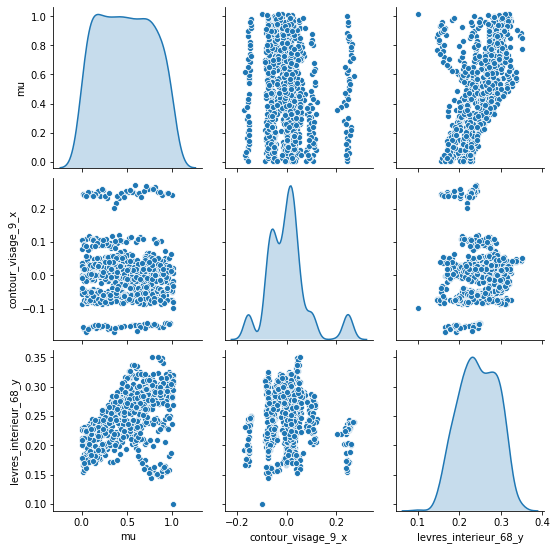

In [19]:
sns.pairplot(train_dataset[['mu','contour_visage_9_x','levres_interieur_68_y']], diag_kind='kde')

In [20]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

In [21]:
train_labels = train_features.pop('mu')
test_labels = test_features.pop('mu')

In [22]:
normalizer = preprocessing.Normalization()
normalizer.adapt(np.array(train_features))
normalizer.mean.numpy()

array([-0.3976027 , -0.18749404, -0.39237714, -0.07159107, -0.37496802,
        0.04433849, -0.34698743,  0.15612838, -0.3059378 ,  0.26002997,
       -0.25095642,  0.35693097, -0.17972602,  0.43955714, -0.0957226 ,
        0.49903765,  0.00322936,  0.5165938 ,  0.10020923,  0.49498132,
        0.18452321,  0.4322191 ,  0.25337794,  0.34468484,  0.30691782,
        0.24570668,  0.34588462,  0.13868254,  0.3706649 ,  0.02627325,
        0.3829587 , -0.08790663,  0.38149065, -0.20065859, -0.3310411 ,
       -0.33954975, -0.2849832 , -0.3984754 , -0.21526003, -0.42308873,
       -0.13831295, -0.42187223, -0.06897698, -0.39177528,  0.05873416,
       -0.39010662,  0.12802196, -0.41848898,  0.2031776 , -0.42065266,
        0.2707923 , -0.39597353,  0.3136728 , -0.33995697,  0.0012731 ,
       -0.28331825,  0.00489003, -0.21759494,  0.00890194, -0.15305358,
        0.01276561, -0.08598842, -0.06901541,  0.00265197, -0.03164802,
        0.01415958,  0.00741492,  0.02306089,  0.04321837,  0.01

In [23]:
def build_and_compile_model(norm = None):
    layers_seq = [
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
    ]
    if norm:
        layers_seq = [norm] + layers_seq
    model = keras.Sequential(layers_seq)

    model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
    return model

In [24]:
dnn_model = build_and_compile_model()

In [25]:
%%time
history = dnn_model.fit(
    np.asarray(train_features).astype(np.float32),
    np.asarray(train_labels).astype(np.float32),
    validation_split=0.2,
    verbose=0, epochs=100)


CPU times: user 3.94 s, sys: 273 ms, total: 4.22 s
Wall time: 3.02 s


In [26]:
hist = pd.DataFrame(history.history)
hist.tail()

,loss,val_loss
95,0.094171,0.084150
96,0.098931,0.101803
97,0.093358,0.079601
98,0.090216,0.095270
99,0.091581,0.081048


In [27]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 1])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

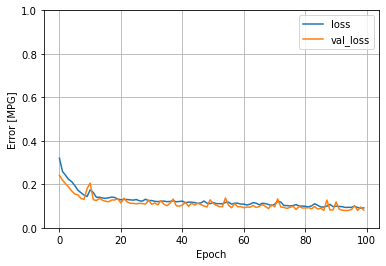

In [28]:
plot_loss(history)

In [29]:
avg_loss = dnn_model.evaluate(np.asarray(test_features).astype(np.float32),
                              np.asarray(test_labels).astype(np.float32))
print('Average loss:', avg_loss)

6/6 [==============================] - 0s 1ms/step - loss: 0.0907
Average loss: 0.09067604690790176


In [30]:
dnn_model.save('mouth_model')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: mouth_model/assets


In [31]:
def test_random_landmark():
    row = raw_dataset.sample()
    mu = row['mu'].iloc[0]
    row.pop('mu')
    landmark = np.array([np.asarray(row)[0].astype(np.float32)])
    predicted_mu = dnn_model.predict(landmark)
    print('mu:', mu)
    print('predicted_mu:', predicted_mu)

In [32]:
test_random_landmark()

mu: 0.7997298240661621
predicted_mu: [[0.85068774]]


# SVM

In [33]:
from sklearn import svm

In [35]:
train_features

,contour_visage_1_x,contour_visage_1_y,contour_visage_2_x,contour_visage_2_y,contour_visage_3_x,contour_visage_3_y,contour_visage_4_x,contour_visage_4_y,contour_visage_5_x,contour_visage_5_y,...,levres_interieur_64_x,levres_interieur_64_y,levres_interieur_65_x,levres_interieur_65_y,levres_interieur_66_x,levres_interieur_66_y,levres_interieur_67_x,levres_interieur_67_y,levres_interieur_68_x,levres_interieur_68_y
873,-0.303454,-0.237542,-0.31073,-0.135677,-0.303454,-0.0338122,-0.281626,0.0753285,-0.267074,0.184469,...,-0.00513603,0.220849,0.0894526,0.235402,-0.00513603,0.184469,-0.0487923,0.184469,-0.0924486,0.169917
568,-0.496118,-0.217666,-0.477555,-0.0939094,-0.446616,0.036035,-0.415677,0.159792,-0.359986,0.271173,...,0.0917255,0.190731,0.128852,0.209294,0.0917255,0.234046,0.0484107,0.246421,0.0112837,0.246421
249,-0.548963,0.0831278,-0.481103,0.191703,-0.406458,0.293492,-0.325027,0.374923,-0.216452,0.435997,...,0.170347,0.117057,0.204277,0.110272,0.183919,0.198489,0.156775,0.225633,0.11606,0.239204
331,-0.364573,-0.123529,-0.35352,-0.00747675,-0.336942,0.103049,-0.303784,0.208049,-0.2651,0.313048,...,0.0388466,0.125154,0.121741,0.163838,0.0388466,0.180417,-0.00536376,0.185944,-0.0495741,0.185944
492,-0.553896,-0.144606,-0.524838,0.000683717,-0.489969,0.13435,-0.443476,0.250582,-0.367925,0.343568,...,0.114437,0.163408,0.137684,0.198278,0.114437,0.273829,0.0911908,0.285452,0.0621328,0.291264
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117,-0.526874,-0.302345,-0.542234,-0.156424,-0.542234,-0.0181836,-0.534554,0.120057,-0.488474,0.235258,...,0.0721699,0.204538,0.08753,0.235258,0.0568098,0.242938,0.0260896,0.242938,-0.00463062,0.242938
464,-0.596431,-0.116916,-0.565901,0.0174206,-0.529263,0.145651,-0.474308,0.261668,-0.401033,0.353261,...,0.136312,0.1945,0.172949,0.1945,0.136312,0.206713,0.105781,0.218925,0.0691437,0.225031
25,-0.39778,-0.205184,-0.390876,-0.0878201,-0.363261,0.0295441,-0.342549,0.140005,-0.30803,0.257369,...,0.0440624,0.16762,0.0923888,0.22285,0.0440624,0.271176,0.00263968,0.27808,-0.0318792,0.271176
110,-0.517823,-0.306801,-0.532864,-0.163907,-0.540385,-0.0210137,-0.525344,0.114359,-0.480219,0.23469,...,0.0687924,0.204608,0.0913545,0.23469,0.0612717,0.22717,0.0236681,0.22717,-0.00641472,0.22717


In [36]:
regr = svm.SVR()

In [37]:
regr.fit(train_features,train_labels)

SVR()

In [43]:
def test_SVR(regr, test_features_set, test_labels_set):
    predicted_labels = regr.predict(test_features_set)
    true_labels = np.asarray(test_labels_set)
    N = len(true_labels)
    return sum(list(map(lambda x: abs(x), list(true_labels-predicted_labels))))/N

In [44]:
test_SVR(regr, test_features, test_labels)

0.1303149881860853

In [46]:
import pickle
with open('mouth_svm.pickle','wb') as pickle_out:
    pickle.dump(regr, pickle_out)